In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa
import librosa.display
import io
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow import keras

### Import wave data

In [2]:
with open('../data/20190926-145102.wav', 'rb') as f:
    wav_data = f.read()

In [3]:
wav_data[0:100]

b'RIFF$\xc0 \x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x00\x10\x00data\x00\xc0 \x00?\xff?\xffW\xffW\xff2\xff2\xff+\xff+\xff:\xff:\xffS\xffS\xff\xce\xff\xce\xff!\x00!\x00=\x00=\x00\n\x00\n\x00\xcb\xff\xcb\xff\xcc\xff\xcc\xff5\xff5\xff\x02\xff\x02\xff'

In [4]:
ipd.Audio(wav_data)

### Parse wave data

In [5]:
sample_rate, y = scipy.io.wavfile.read(io.BytesIO(wav_data))

In [6]:
sample_rate

44100

In [7]:
y.shape

(536576, 2)

In [8]:
y.shape[0] / sample_rate

12.167256235827665

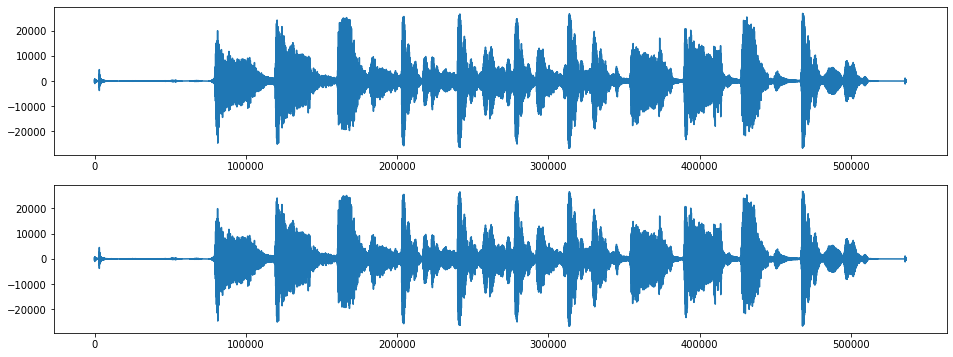

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 6))
axs[0].plot(y[:, 0])
axs[1].plot(y[:, 1])

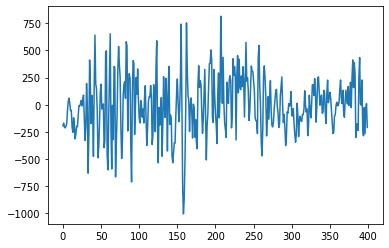

In [10]:
plt.plot(y[0:400, 0])

### Change to float32 for transition to mono

In [11]:
mono_y = y.astype(np.float32) / np.iinfo(np.int16).max
mono_y = librosa.to_mono(mono_y.T)

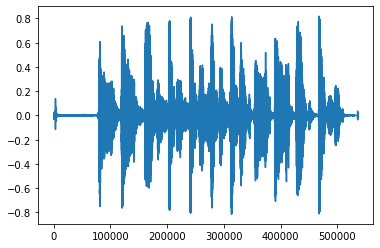

In [12]:
plt.plot(mono_y)

### Resample to preferred sampling rate

In [13]:
resampled_y = librosa.resample(mono_y, sample_rate, 16000)

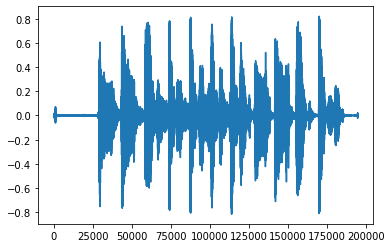

In [14]:
plt.plot(resampled_y)

In [15]:
ipd.Audio(resampled_y, rate=16000)

### Normalize samples

In [16]:
normalized_y = librosa.util.normalize(resampled_y, norm=np.inf)

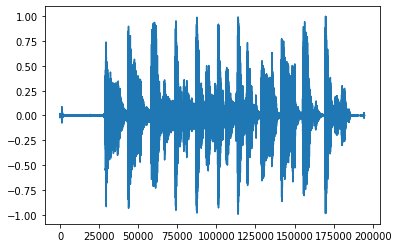

In [17]:
plt.plot(normalized_y)

In [18]:
ipd.Audio(normalized_y, rate=16000)

In [19]:
normalized_wav = io.BytesIO()
scipy.io.wavfile.write(normalized_wav, 16000, (normalized_y * np.iinfo(np.int16).max).astype(np.int16))

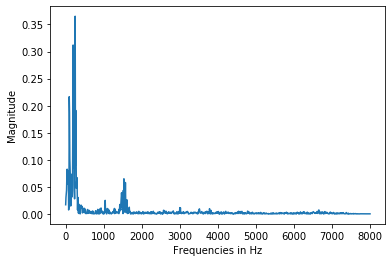

In [20]:
n_fft = 2048
time = 1.7
D = np.abs(librosa.stft(normalized_y[int(time*16000):(int(time*16000) + n_fft)], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(librosa.fft_frequencies(16000, 2048), D);
plt.xlabel('Frequencies in Hz')
plt.ylabel('Magnitude');

In [21]:
D = np.abs(librosa.stft(normalized_y, n_fft=n_fft, hop_length=512))
DB = librosa.amplitude_to_db(D, ref=np.max)

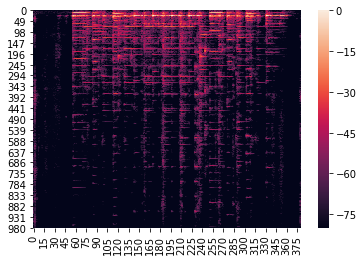

In [22]:
sns.heatmap(DB)

In [23]:
mel = librosa.feature.melspectrogram(
    normalized_y,
    16000,
    n_fft=2048,
    hop_length=512,
    n_mels=229,
    fmin=30.0
)

In [24]:
normalized_y.shape[0] / 381

510.96325459317586

In [25]:
mel.shape

(229, 381)

In [26]:
spec = librosa.power_to_db(mel)

In [27]:
spec.shape

(229, 381)

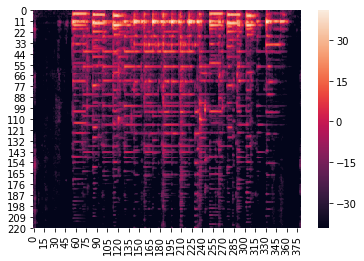

In [28]:
sns.heatmap(spec)

In [29]:
spec.shape

(229, 381)

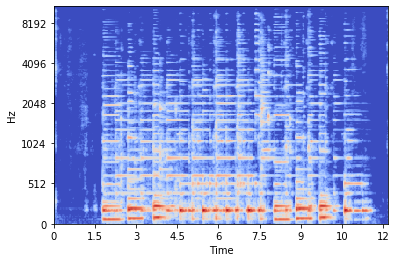

In [30]:
librosa.display.specshow(spec, sr=16000, hop_length=512, 
                         x_axis='time', y_axis='mel');
#plt.colorbar(format='%+2.0f dB');

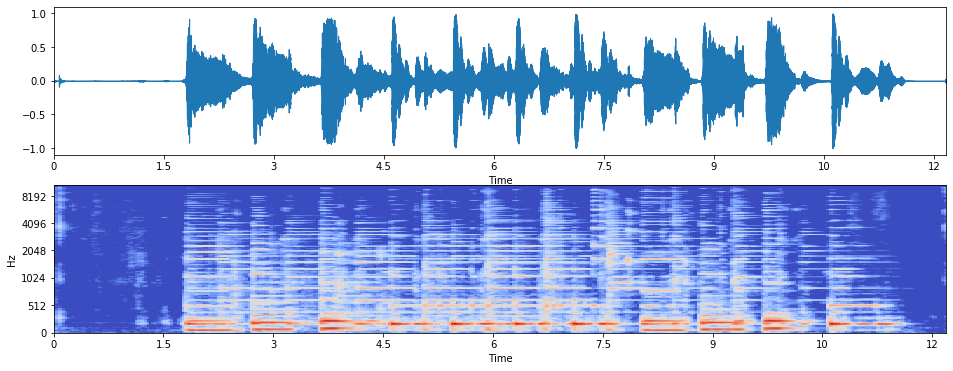

In [31]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 6))
librosa.display.waveplot(normalized_y, sr=16000, ax=axs[0])
librosa.display.specshow(spec, sr=16000, hop_length=512, x_axis='time', y_axis='mel', ax=axs[1]);

In [32]:
import json
with open('../data/20190926-145102.json', 'r') as f:
    notes = json.load(f)

In [33]:
notes_df = pd.DataFrame.from_records(notes, columns=['pitch', 'onset', 'offset', 'velocity'])

In [34]:
notes_df.head(5)

pitch  onset  offset  velocity
0     59  1.120   1.152        25
1     59  1.472   1.536        22
2     83  1.792   1.824        68
3     55  1.792   2.240        66
4     55  2.240   2.368        62

In [35]:
notes[0]

[59, 1.12, 1.1520000000000001, 25]

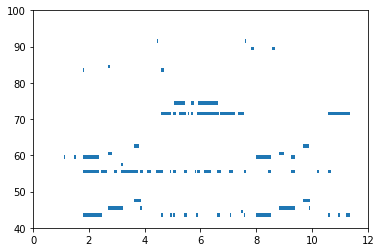

In [36]:
fig, ax = plt.subplots(1)
ax.set_xlim((0, 12))
ax.set_ylim((40, 100))
for note in notes:
    rect = patches.Rectangle((note[1], note[0]), note[2] - note[1], 1, linewidth=1)
    ax.add_patch(rect)
plt.show()

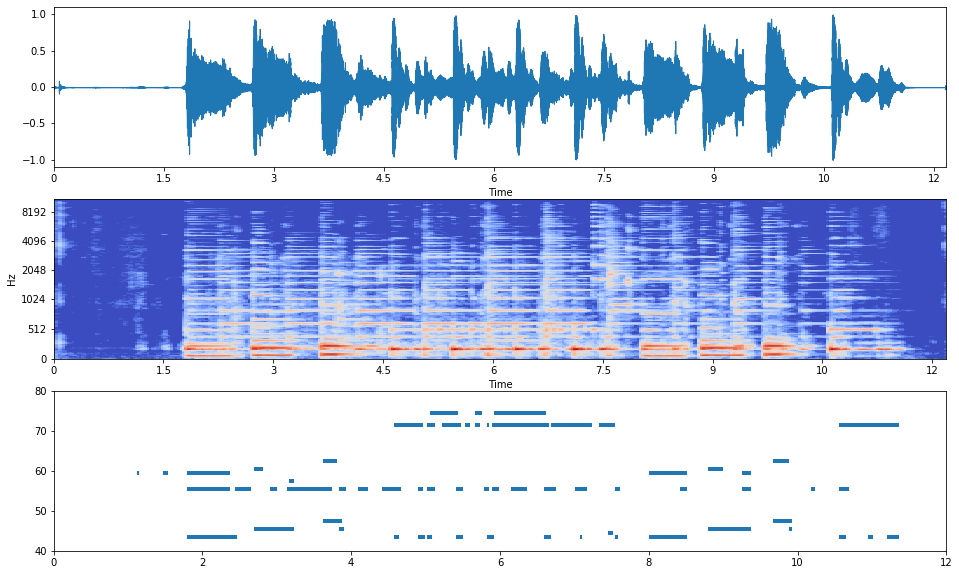

In [37]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
librosa.display.waveplot(normalized_y, sr=16000, ax=axs[0])
librosa.display.specshow(spec, sr=16000, hop_length=512, x_axis='time', y_axis='mel', ax=axs[1]);
axs[2].set_xlim((0, 12))
axs[2].set_ylim((40, 80))
for note in notes:
    if note[0] < 80:
        rect = patches.Rectangle((note[1], note[0]), note[2] - note[1], 1, linewidth=1)
        axs[2].add_patch(rect)

In [38]:
mel.shape

(229, 381)

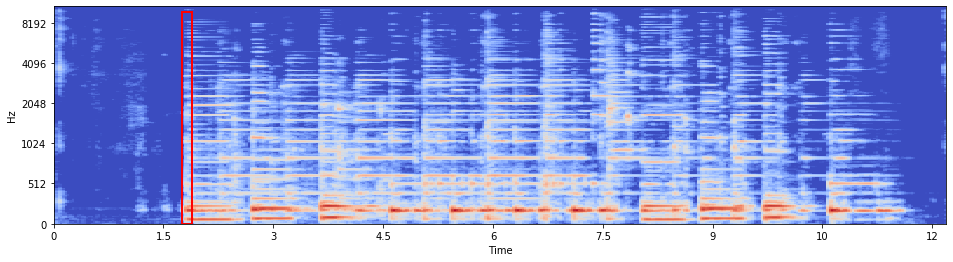

In [39]:
frame = 55
start = frame * 512 / 16000
end = 2048 / 16000
fig, ax = plt.subplots(figsize=(16, 4))
librosa.display.specshow(spec, sr=16000, hop_length=512, x_axis='time', y_axis='mel', ax=ax)
rect = patches.Rectangle((start, 10000), end, -10000, linewidth=2, facecolor='none', edgecolor='r')
ax.add_patch(rect)

In [40]:
512 / 16000

0.032

In [41]:
2048 / 16000

0.128

### Build the model

In [42]:
MIN_MIDI_PITCH = librosa.note_to_midi('A0')
MAX_MIDI_PITCH = librosa.note_to_midi('C8')
MIDI_PITCHES = MAX_MIDI_PITCH - MIN_MIDI_PITCH + 1

In [43]:
MIDI_PITCHES

88

In [44]:
mel_inputs = keras.Input((381, 229, 1))
x = Conv2D(48, (3, 3), activation='relu')(mel_inputs)
x = BatchNormalization()(x)
x = Conv2D(48, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(96, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
_, _, width, height = x.shape
x = Reshape((-1, width * height))(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.5)(x)
forward_layer = LSTM(256, return_sequences=True)
backward_layer = LSTM(256, return_sequences=True, go_backwards=True)
x = Bidirectional(forward_layer, backward_layer=backward_layer)(x)
outputs = Dense(88, activation='sigmoid')(x)

onset_model = keras.Model(inputs=mel_inputs, outputs=outputs, name='onset_acoustic')

x = Conv2D(48, (3, 3), activation='relu')(mel_inputs)
x = BatchNormalization()(x)
x = Conv2D(48, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(96, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
_, _, width, height = x.shape
x = Reshape((-1, width * height))(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.5)(x)
forward_layer = LSTM(256, return_sequences=True)
backward_layer = LSTM(256, return_sequences=True, go_backwards=True)
x = Bidirectional(forward_layer, backward_layer=backward_layer)(x)
offset_outputs = Dense(88, activation='sigmoid')(x)

offset_model = keras.Model(inputs=mel_inputs, outputs=offset_outputs, name='offset_acoustic')

x = Conv2D(48, (3, 3), activation='relu')(mel_inputs)
x = BatchNormalization()(x)
x = Conv2D(48, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(96, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), strides=(1, 2))(x)
x = Dropout(0.25)(x)
_, _, width, height = x.shape
x = Reshape((-1, width * height))(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(88, activation='sigmoid')(x)
x = concatenate([outputs, x, offset_outputs])
forward_layer = LSTM(256, return_sequences=True)
backward_layer = LSTM(256, return_sequences=True, go_backwards=True)
x = Bidirectional(forward_layer, backward_layer=backward_layer)(x)
pitch_outputs = Dense(88, activation='sigmoid')(x)

pitch_model = keras.Model(inputs=mel_inputs, outputs=pitch_outputs, name='pitch_model')

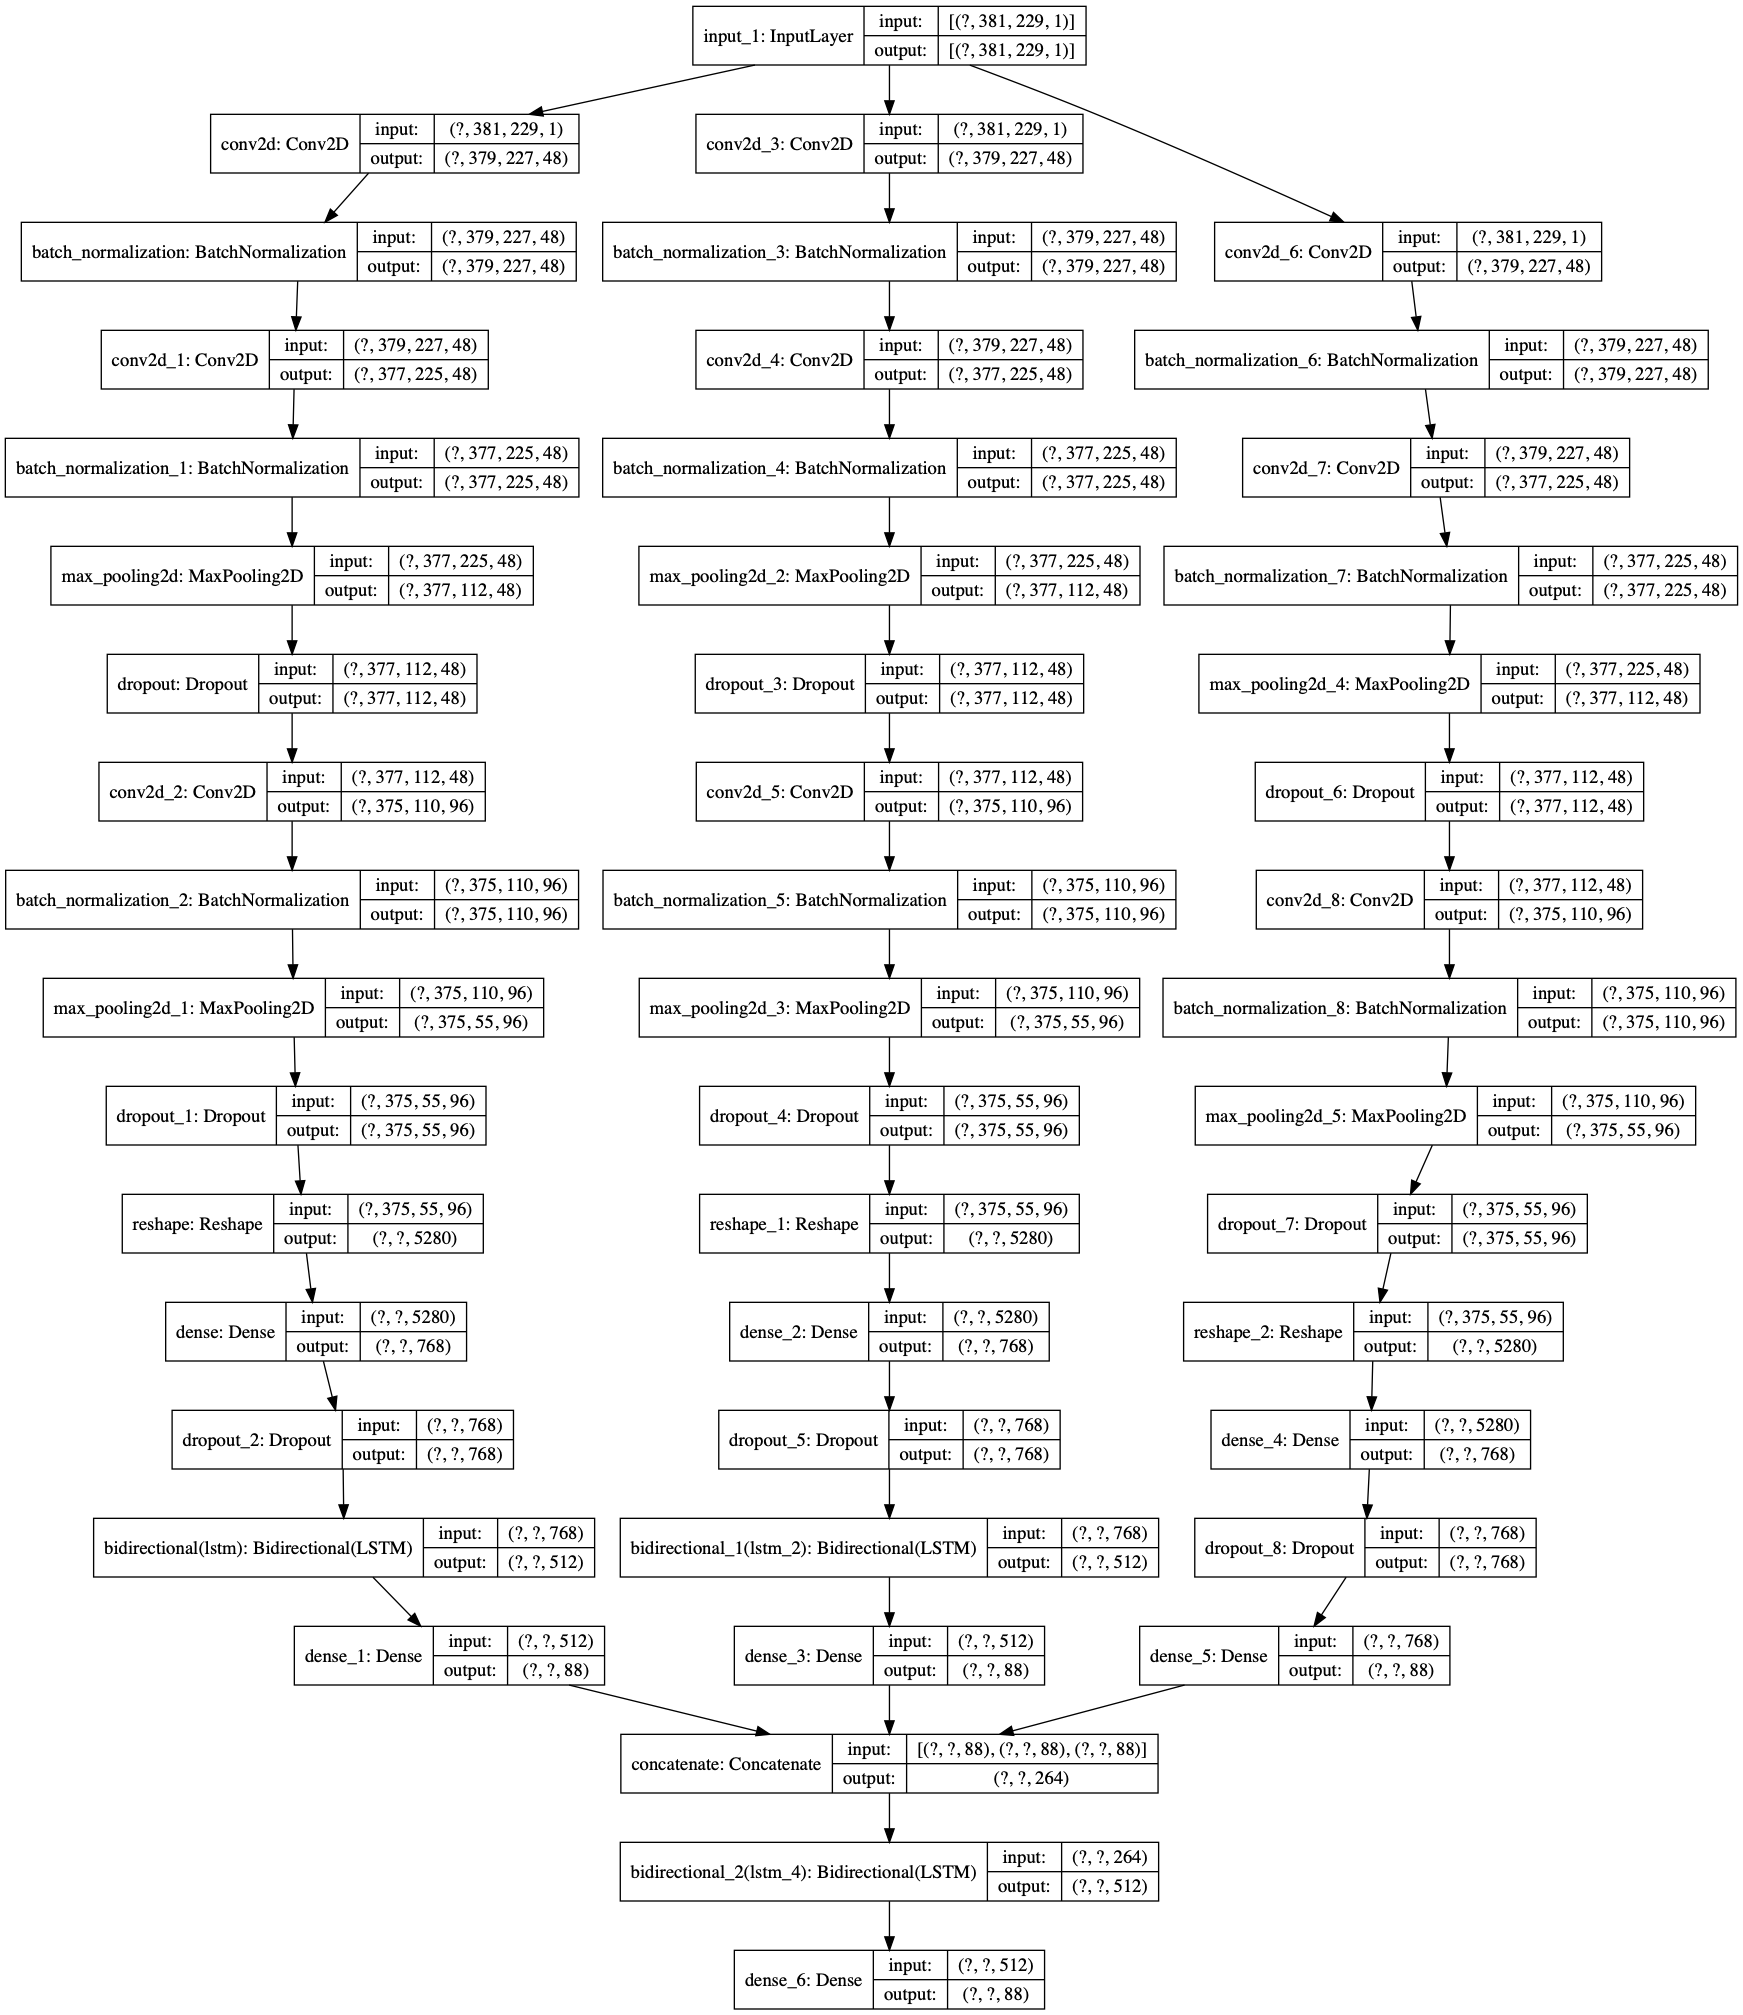

In [45]:
tf.keras.utils.plot_model(pitch_model, 'onset.png', show_shapes=True)

In [46]:
x_train = np.array([mel.T.reshape((381, 229, 1))] * 1000)
x_test = np.array([mel.T.reshape((381, 229, 1))] * 100)

In [47]:
onset_label = np.zeros((381, 88))
notes
onset_label.shape

(381, 88)

In [48]:
onsets_per_frame = []
for i in np.arange(0, 375):
    onsets = np.zeros(88)
    current_second = i * 512 / 16000
    for pitch, start, _, _ in notes:
        if current_second >= start and current_second < start + 512 / 16000:
            onsets[pitch - MIN_MIDI_PITCH] = 1
    onsets_per_frame.append(onsets)

onset_label = np.array(onsets_per_frame)

In [49]:
y_train = np.array([onset_label] * 1000)
y_test = np.array([onset_label] * 100)

In [50]:
print(x_train.shape)
print(y_train.shape)

(1000, 381, 229, 1)
(1000, 375, 88)


In [51]:
y_train.reshape((1000, -1,)).shape

(1000, 33000)

In [52]:
mel.shape

(229, 381)

In [53]:
onset_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = onset_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=1,
                    validation_split=0.2)
test_scores = onset_model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Train on 800 samples, validate on 200 samples
800/800 [==============================] - 316s 395ms/sample - loss: 0.5940 - accuracy: 0.0359 - val_loss: 0.4392 - val_accuracy: 0.0373
100/1 - 9s - loss: 0.4392 - accuracy: 0.0373
Test loss: 0.43917950987815857
Test accuracy: 0.037333332
